In [1]:
import wmfdata as wmf
import pandas as pd
import numpy as np
from wmfdata import spark,hive
from datetime import datetime

You are using Wmfdata v2.0.0, but v2.0.1 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md.


In [2]:
file = "https://analytics.wikimedia.org/published/datasets/knowledge_gaps/content_gaps/csv/geography_wmf_region.csv"
geodata = pd.read_csv(file)

# filter for wikipedia projects
wikis=pd.read_csv('data/wikis')
geodata=geodata[geodata.wiki_db.isin(list(wikis['database_code']))]

In [3]:
# Since each snapshot contains patial data of the month it is published it in: we filter the data from previous month if the data was pulled too early. *Needs to be double checked.

# Convert 'time_bucket' to datetime for comparison
#geodata['time_bucket'] = pd.to_datetime(geodata['time_bucket'])


# If today's day is before the 23rd of the month, filter out the previous month's data.  
#if datetime.now().day < 23:
#    prev_month = datetime.now().month - 1 if datetime.now().month > 1 else 12
#    geodata = geodata[geodata['time_bucket'].dt.month != prev_month]

In [11]:
old_geo_data = pd.read_csv('data/updated_geo_data.csv') # load current geo_data table

old_geo_data['time'] = pd.to_datetime(old_geo_data['time'])

In [12]:
# Group and pivot the geodata

    
quality_totals = geodata.groupby(['time_bucket', 'category'])['standard_quality_count_value'].sum().reset_index()
quality_totals_pivot = quality_totals.pivot(index='time_bucket', columns='category', values='standard_quality_count_value').reset_index()

quality_totals_pivot['time'] = pd.to_datetime(quality_totals_pivot['time_bucket'])

cols_to_rename = {col: col + " total" for col in quality_totals_pivot.columns if col not in ['time_bucket', 'category', 'time']}
quality_totals_pivot = quality_totals_pivot.rename(columns=cols_to_rename)


quality_totals_pivot= quality_totals_pivot[quality_totals_pivot['time'] != '2023-09-01']

In [13]:
# Identify the latest 'time' in old_geo_data

latest_time = old_geo_data['time'].max()

# Filter rows from total quality articles where 'time' is greater than latest_time from old_data to identify rows to be added
filtered_rows = quality_totals_pivot[quality_totals_pivot['time'] > latest_time]

# Filter columns of last_row based on columns in geo_data
old_geo_data = pd.concat([old_geo_data, filtered_rows], axis=0, ignore_index=True, sort=False)

old_geo_data = old_geo_data.drop(columns="time_bucket")


In [14]:
# check if new data was appended to the original csv file.

'''
The code below computes the monthly metric and the quarterly metric in the following way:

1) Monthly metric: Contained in the column called 'metric_underrepresented'.  It is computed as the yoy-difference from 2022 and 2023 (difference calculated over 12 periods).  

2) Quarterly metric: Conatained in the column called 'quarterly_metric'.  It is computed as the average of yoy-difference of the monthly metrics of July 2023 and August 2023.  Since September data is not fully available, 
it is just the average of the first 2 months in the quarter (July and August).

'''

if filtered_rows.empty:
    print("No data has been added to the original spreadsheet. Will not overwrite updated_geo_data.csv")
    

else:
    # Compute yoy difference 

    # Calculate the 12-month YoY difference for each region
    old_geo_data['Latin America & Caribbean yoy'] = old_geo_data['Latin America & Caribbean total'].diff(12).round(0)
    old_geo_data['Central & Eastern Europe & Central Asia yoy'] = old_geo_data['Central & Eastern Europe & Central Asia total'].diff(12).round(0)
    old_geo_data['East, Southeast Asia, & Pacific yoy'] = old_geo_data['East, Southeast Asia, & Pacific total'].diff(12).round(0)
    old_geo_data['North America yoy'] = old_geo_data['North America total'].diff(12).round(0)
    old_geo_data['Northern & Western Europe yoy'] = old_geo_data['Northern & Western Europe total'].diff(12).round(0)
    old_geo_data['Middle East & North Africa yoy'] = old_geo_data['Middle East & North Africa total'].diff(12).round(0)
    old_geo_data['Sub-Saharan Africa yoy'] = old_geo_data['Sub-Saharan Africa total'].diff(12).round(0)
    old_geo_data['South Asia yoy'] = old_geo_data['South Asia total'].diff(12).round(0)
    old_geo_data['UNCLASSED yoy'] = old_geo_data['UNCLASSED total'].diff(12).round(0)

    
    # Get a list of columns that contain 'yoy'
    yoy_columns = [col for col in old_geo_data.columns if 'yoy' in col]

    # Sum the yoy
    old_geo_data['sum'] = old_geo_data[yoy_columns].sum(axis=1)
    

    # List of underrepresented regions
    underrepresented_regions = [
        "East, Southeast Asia, & Pacific yoy", 
        "Latin America & Caribbean yoy", 
        "Middle East & North Africa yoy" , 
        "South Asia yoy", 
        "Sub-Saharan Africa yoy"
    ]
    
    # Define the columns to adjust to get quarterly average
    columns_to_adjust = [
        'Latin America & Caribbean yoy',
        'Central & Eastern Europe & Central Asia yoy',
        'East, Southeast Asia, & Pacific yoy',
        'North America yoy',
        'Northern & Western Europe yoy',
        'Middle East & North Africa yoy',
        'Sub-Saharan Africa yoy',
        'South Asia yoy',
        'UNCLASSED yoy'
    ]

    
# Monthly 
    # Compute the sum of underrepresented regions
    old_geo_data['underrepresented_sum'] = old_geo_data[underrepresented_regions].sum(axis=1)

    # Calculate the proportion of underrepresented regions to total
    old_geo_data['metric_underrepresented'] = (old_geo_data['underrepresented_sum'] / old_geo_data['sum']) *100

    # drop underrepresented sum
    old_geo_data.drop('underrepresented_sum', axis=1, inplace=True)
    
    # round and turn into percentage
    #old_geo_data['underrepresented'] = old_geo_data['metric_underrepresented'] 
    #old_geo_data['metric_underrepresented'] = (old_geo_data['metric_underrepresented'] * 100).round()
    #old_geo_data['metric_underrepresented'] = old_geo_data['metric_underrepresented'].replace([np.inf, -np.inf, np.nan], 0).astype(int).astype(str) + '%'
    
# Quarterly

    # Get Quarterly metric which is the average of July and August.
    old_geo_data['time'] = pd.to_datetime(old_geo_data['time'])

    # 2. Create a copy of the DataFrame
    copied_df = old_geo_data.copy()

    # 3. Filter the copied DataFrame for the rows of August and July 2023
    august_july_data = copied_df[(copied_df['time'].dt.month.isin([8, 7])) & (copied_df['time'].dt.year == 2023)]

    # 4. Calculate the average values for August and July only for columns that contain 'total' or 'yoy'
    cols_to_average = [col for col in august_july_data.columns if 'total' in col or 'yoy' in col]
    average_values = august_july_data[cols_to_average].mean()

    # Replace values in the row corresponding to '2023-08-01' with average_values
    copied_df.loc[copied_df['time'] == '2023-08-01', cols_to_average] = average_values.values
    copied_df['sum'] = copied_df[columns_to_adjust].sum(axis=1)

    # 5. Calculate the quarterly metric for the entire DataFrame
    copied_df['quarterly_metric'] = (copied_df[underrepresented_regions].sum(axis=1) / copied_df['sum']) * 100

    # 6. Append the created quarterly_metric column to old_geo_data
    old_geo_data['quarterly_metric'] = copied_df['quarterly_metric']
    


    # output
    print("updating csv file")
    old_geo_data.to_csv('data/updated_geo_data.csv', index=False)

updating csv file


In [15]:
old_geo_data.tail(1)

,time,Latin America & Caribbean total,Central & Eastern Europe & Central Asia total,"East, Southeast Asia, & Pacific total",North America total,Northern & Western Europe total,Middle East & North Africa total,Sub-Saharan Africa total,South Asia total,UNCLASSED total,...,"East, Southeast Asia, & Pacific yoy",North America yoy,Northern & Western Europe yoy,Middle East & North Africa yoy,Sub-Saharan Africa yoy,South Asia yoy,UNCLASSED yoy,sum,metric_underrepresented,quarterly_metric
271,2023-08-01,59840,243669,162059,179267,548327,36411,28039,43486,267.0,...,13385.0,9547.0,37690.0,2907.0,2807.0,4224.0,NaN,92984.0,28.554375,28.282146


# Naive Forecast

In [16]:
'''
The forecast is calculated by getting the difference between the change in the average metric from Q2 2022 and Q3 2022 and then adding that change onto the calculated quarterly metric
for Q2 2023 (the average of July and August).


'''


# Define the months for Q2 and Q3
q2_dates = ['2022-04-01', '2022-05-01', '2022-06-01']
q3_dates = ['2022-07-01', '2022-08-01', '2022-09-01']

# Filter the data for Q2 and Q3 2022 separately
q2_data = old_geo_data[old_geo_data['time'].isin(q2_dates)].copy()
q3_data = old_geo_data[old_geo_data['time'].isin(q3_dates)].copy()

# Compute the average of combined underrepresented regions YoY differences and divide by total for Q2 and Q3
avg_combined_q2 = q2_data[underrepresented_regions].sum(axis=1).mean() / q2_data['sum'].mean()
avg_combined_q3 = q3_data[underrepresented_regions].sum(axis=1).mean() / q3_data['sum'].mean()

# Compute the delta between Q3 and Q2
delta = avg_combined_q3 - avg_combined_q2

# Get the last available value of quarterly_metric
last_quarterly_metric = old_geo_data[old_geo_data['time'] == '2023-08-01']['quarterly_metric'].values[0]

# Forecast for Q3 2023
forecast_q3 = last_quarterly_metric + delta

# Display results
print(f"Delta between Q2 and Q3 2022: {delta*100:.2f} percentage points")
print(f"Last available quarterly metric (August 2023): {last_quarterly_metric:.2f}%")
print(f"Forecast for Q3 2023: {forecast_q3:.2f}%")


Delta between Q2 and Q3 2022: -1.98 percentage points
Last available quarterly metric (August 2023): 28.28%
Forecast for Q3 2023: 28.26%


# Monthly Metric Graph

Generating region chart..
           time  Latin America & Caribbean total  \
0    2001-01-01                                0   
1    2001-02-01                                0   
2    2001-03-01                                0   
3    2001-04-01                                0   
4    2001-05-01                                0   
..          ...                              ...   
267  2023-04-01                            58862   
268  2023-05-01                            59063   
269  2023-06-01                            59231   
270  2023-07-01                            59538   
271  2023-08-01                            59840   

     Central & Eastern Europe & Central Asia total  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   
..                       

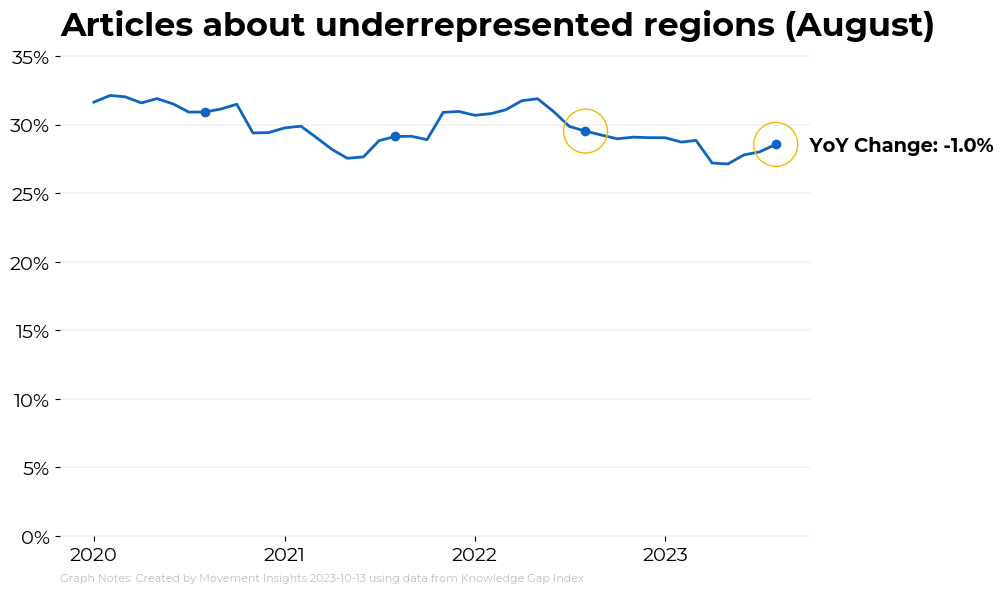

In [17]:
%run geo_data_plot.ipynb